# Statistical inference for scientists
Definitions:
* P(A) - probability of event A occurring
* P(A|B) - conditional probability of event A happening given event B happened.

In science we are concerned with the relationship between experimental data ($E$) and a scientific hypothesis ($H$). There are two types of statistical inference available: frequentist and Bayesian. In this article we will discuss the difference between these two approaches and when they should be applied.
> "A problem well-stated is a problem half-solved" -Charles Kettering

They key difference between frequentist and Bayesian approaches is how they treat experimental data ($E$) and hypothesis ($H$).

**Frequentist approach**. In frequentist approach we are concerned with the probability of event $E$ occuring *given* hypothesis ($H$). Experimental outcome ($E$) is a *variable* with the probability distribution $P(E|H)$ given the *fixed* hypothesis ($H$). It is natural to think of an experiment as a repeateable process giving rise to frequencies of events ($E$) converging to hypothesis $H$ hence the name "frequentist". $P(E|H)$ is usually called the *likelihood*.

**Bayesian approach**. In Bayesian approach we are interested in probability distribution of hypothesis ($H$) *given* experimental data ($E$). Bayesians see the outcome of an experiment ($E$) as *fixed* and treat it as an an *e*vidence while hypothesis ($H$) is treated as a variable with varying degrees of belief. Bayes' formula allows us to update from our *prior* belief, $P(H)$, to *posterior* belief, $P(H|E)$, in the light of new evidence ($E$):

<center>$P(H|E) = \dfrac{P(E|H) P(H)}{P(E)}$</center>

* $P(H)$ is the probability of the hypothesis before we see the evidence, called the prior probability, or just *prior*.
* $P(H|E)$ is what we want to compute, the probability of the hypothesis after we see the evidence, called the *posterior*.
* $P(E|H)$ is the probability of the data under the hypothesis, called the *likelihood*.
* $P(E)$ is the probability of the data under any hypothesis, usually treated as the normalizing constant.

# Frequentist approach
For concreteness let's consider an example of a singe molecule FRET experiment where we measure the unwinding duration time ($t$) of individual helicases. Our hypothesis will be a simple n-step unwinding model with stepping rate k. The likelihood function is a gamma distribution:
<center>$p(t|k,n) = \dfrac{k^{n}t^{n-1}e^{-kt}}{\Gamma(n)}$</center>

*Let's* say we know model parameters (let's say n=4 and k=15) and we would like to **predict** frequencies of observing unwinding events with t = 0.2, 0.4, 0.6 sec. Since we want to compute $P(E|H)$ we will use frequentist approach.

In [52]:
from scipy import stats, special
import matplotlib.pyplot as plt
import numpy as np
import lmfit
import corner

In [73]:
print('Probability densities of t given n=4 and k=15')
print('--------------------------------------------------')
n = 4
k = 15
t1, t2, t3 = 0.2, 0.4, 0.6
p1 = stats.gamma.pdf(t1, n, loc=0, scale=1/k)
p2 = stats.gamma.pdf(t2, n, loc=0, scale=1/k)
p3 = stats.gamma.pdf(t3, n, loc=0, scale=1/k)
print('p(t={}|n=4, k=15) = {:.3f}'.format(t1, p1))
print('p(t={}|n=4, k=15) = {:.3f}'.format(t2, p2))
print('p(t={}|n=4, k=15) = {:.3f}'.format(t3, p3))

Probability densities of t given n=4 and k=15
--------------------------------------------------
p(t=0.2|n=4, k=15) = 3.361
p(t=0.4|n=4, k=15) = 1.339
p(t=0.6|n=4, k=15) = 0.225


We can test it by making repeated measurements (size=250).

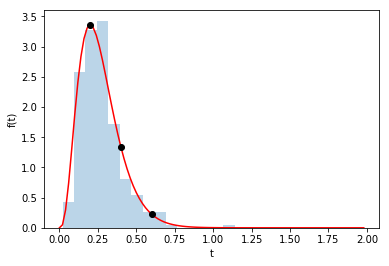

In [74]:
x = stats.gamma.rvs(n, loc=0, scale=1/k, size=250, random_state=42) # let's make size=250 measurements
plt.hist(x, normed=True, bins=15, alpha=0.3) # plot experimental results as a histogram
plt.plot(np.arange(0,2,0.02), stats.gamma.pdf(np.arange(0,2,0.02), n, loc=0, scale=1/k), 'r') # plot predicted probabilities
plt.plot([t1, t2, t3], [p1, p2, p3], 'o', color='k')
plt.xlabel('t')
plt.ylabel('f(t)')
plt.show()

# Maximum-likelihood estimation
Now suppose we collected data (size=200) and want to find a pair of parameters (k,n) that best describes our data. We can determine point estimates of k and n by maximizing likelihood function.

[[Variables]]
    n:   4.28712103 (init= 3)
    k:   15.6219592 (init= 20)


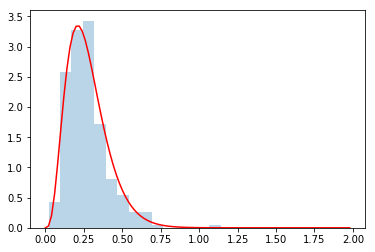

In [75]:
pars = lmfit.Parameters()
pars.add_many(('n', 3), ('k', 20))
pars['n'].min = 0
pars['k'].min = 0

def log_likelihood(p):
    return np.sum(p['n']*np.log(p['k']) + (p['n']-1)*np.log(x) - p['k']*x - np.log(special.gamma(p['n'])))

def nll(p):
    '''negative log-likelihood'''
    return -log_likelihood(p)

# we will minimize nll (scalar value) using nelder's method
mi = lmfit.minimize(fcn=nll, params=pars, method='nelder')
lmfit.printfuncs.report_fit(mi.params, min_correl=0.5)
plt.hist(x, bins=15, normed=True, alpha=0.3)
plt.plot(np.arange(0,2,0.02), stats.gamma.pdf(np.arange(0,2,0.02), mi.params['n'], 0, 1/mi.params['k']), 'r')
plt.show()

# Bayesian approach
What if instead of point estimates we want to determine the range of parameters (k,n) that contain true values of k and n with some probability? We want to find P(H|E) given E. This question is answered using Bayesian approach. Log representation is simpler and numerically more stable (normalization factor is removed):
<center>$log(posterior) = log(likelihood) + log(prior)$</center>

How do we select prior? The prior, P(H), allows us to include other information we know about parameters before doing the experiment ($D$). If we want to let the data speak for themselves we can select a *uniform* prior (p(H) = 1 within the bounds and P(H) = 0 outside the bouds of parameters, equivalently, log(P(H) = 0 and log(P(H)) = -inf).

In [48]:
def log_prior(p):
    if p['n'] <= 0 or p['k'] <= 0:
        return -np.inf
    else:
        return 0

def log_likelihood(p):
    return np.sum(p['n']*np.log(p['k']) + (p['n']-1)*np.log(x) - p['k']*x - np.log(special.gamma(p['n'])))
    
def log_posterior(p):
    return log_prior(p) + log_likelihood(p)

mini = lmfit.Minimizer(log_posterior, mi.params)
res = mini.emcee(burn=300, steps=1000, thin=20)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.89it/s]


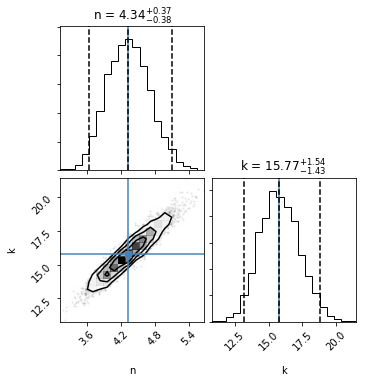

median of posterior probability distribution
--------------------------------------------
[[Variables]]
    n:   4.33598812 +/- 0.378948 (8.74%) (init= 4.287121)
    k:   15.7679483 +/- 1.494923 (9.48%) (init= 15.62196)
[[Correlations]] (unreported correlations are <  0.100)
    C(n, k)                      =  0.945 


In [55]:
corner.corner(res.flatchain, quantiles=[0.025, 0.5, 0.975], labels=res.var_names, truths=list(res.params.valuesdict().values()),
             show_titles=True)
plt.show()
print("median of posterior probability distribution")
print('--------------------------------------------')
lmfit.report_fit(res.params)

Bayesian interpretation of credible region (CR):
>Given our observation data, there is 95% probability that the true values of $k$ and $n$ fall within CR.

In [56]:
# find the maximum likelihood solution
highest_prob = np.argmax(res.lnprob)
hp_loc = np.unravel_index(highest_prob, res.lnprob.shape)
mle_soln = res.chain[hp_loc]
for i, par in enumerate(pars):
    pars[par].value = mle_soln[i]
    
print("\nMaximum a Posteriori")
print('-----------------------------')
lmfit.report_fit(pars)


Maximum a Posteriori
-----------------------------
[[Variables]]
    n:   4.28684257 (init= 3)
    k:   15.6134910 (init= 20)


# Frequentist confidence interval?!

A more widespread approach to calculate confidence interval is using the frequentist approach:
1. True values of $k_{true}$ and $n_{true}$ are fixed. ($H_{true}$ is fixed)
2. Imagine performing lots of (hypothetical) experiments ($E_{1}, E_{2}, E_{3}, ...$) each with size=250. Then we find best fits sampling parameters ($H_{1}, H_{2}, H_{3}, ...$) using MLE.
3. These sampling parameters will follow some distribution and we can find an interval ($H_{true} - c_{1}, H_{true} + H_{2}$) where 95% of $H_{i}$ will lie
<center>$P(H_{true} - c_{1} \leq H_{i} \leq H_{true} + c_{2}) = 0.95$</center>

In [105]:
X = []
K = []
N = []
for i in range(10000):
    X.append(stats.gamma.rvs(n, loc=0, scale=1/k, size=250)) # let's make size=250 measurements
    x = X[i]
    mi = lmfit.minimize(fcn=nll, params=pars, method='nelder')
    K.append(mi.params['k'])
    N.append(mi.params['n'])

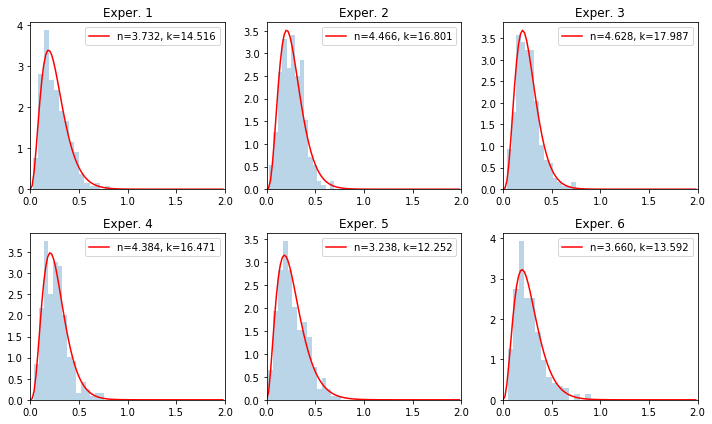

In [106]:
plt.figure(figsize=[10,6])
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.hist(X[i], normed=True, bins=15, alpha=0.3) # plot experimental results as a histogram
    plt.plot(np.arange(0,2,0.02), stats.gamma.pdf(np.arange(0,2,0.02), N[i], loc=0, scale=1/K[i]), 'r', 
             label='n={:.3f}, k={:.3f}'.format(N[i].value, K[i].value)) # plot predicted probabilities
    #plt.plot([t1, t2, t3], [p1, p2, p3], 'o', color='k')
    #plt.xlabel('t')
    plt.title('Exper. {}'.format(i+1))
    plt.xlim(0,2)
    plt.legend()
    plt.tight_layout()
plt.show()

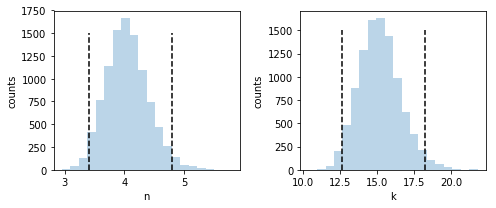

In [129]:
plt.figure(figsize=[7,3])
plt.subplot(1,2,1)
N_sorted = sorted(N)
K_sorted = sorted(K)
n_c1 = n - N_sorted[250].value
n_c2 = N_sorted[9750].value - n
k_c1 = k - K_sorted[250].value
k_c2 = K_sorted[9750].value - k
plt.hist(N, bins=20, alpha=0.3)
plt.vlines(n - n_c1, 0, 1600, color='k', linestyles='dashed')
plt.vlines(n + n_c2, 0, 1600, color='k', linestyles='dashed')
plt.ylabel('counts')
plt.xlabel('n')
plt.subplot(1,2,2)
plt.hist(K, bins=20, alpha=0.3)
plt.vlines(k - k_c1, 0, 1600, color='k', linestyles='dashed')
plt.vlines(k + k_c2, 0, 1600,  color='k', linestyles='dashed')
plt.ylabel('counts')
plt.xlabel('k')
plt.tight_layout()
plt.show()

In [120]:
n_c1, n_c2

(0.585, 0.803)

In [121]:
k_c1, k_c2

(2.331, 3.236)

<center>$P(4 - 0.585 \leq n_{i} \leq 4 + 0.803) = 0.95$</center>
<center>$P(15 - 2.331 \leq k_{i} \leq 15 + 3.236) = 0.95$</center>

Notice that these probabilities tell us something about sample parameters $n_{i}$ and $k_{i}$, but nothing about true values of $n_{true}$ and $k_{i}$.  Let's modify inequalities:
<center>$H_{true} - c_{1} \leq H_{i} \leq H_{true} + c_{2}$</center>
<center>$-c_{1} \leq H_{i} - H_{true} \leq c_{2}$</center>
<center>$-H_{i} - c_{1} \leq -H_{true} \leq -H_{i} + c_{2}$</center>
<center>$P(H_{i} - c_{2} \leq H_{true} \leq H_{i} + c_{1}) = 0.95$</center>

Now we can obtain confidence intervals for true values $n_{true}$ and $k_{true}$ from sampling measurements:
<center>$P(n_{i} - 0.803 \leq n_{true} \leq n_{i} + 0.585) = 0.95$</center>
<center>$P(k_{i} - 3.236 \leq k_{true} \leq k_{i} + 2.331) = 0.95$</center>

Frequentist interpretation of confidence interval (CI):
> There is 95% probability that when I compute CI from data of this sort, the true value will fall within CI.

It is important to note that in freqeuntist approach the true value is treated as fixed and CI is treated as a variable as you can see below.

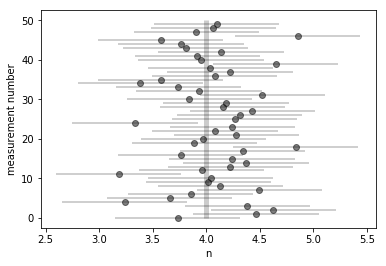

In [126]:
fig, ax = plt.subplots()
ax.errorbar(N[:50], np.arange(50), xerr=n_c1, fmt='ok', ecolor='gray', alpha=0.5)
ax.vlines([n], 0, 50, linewidth=5, alpha=0.2)
ax.set_xlabel("n");ax.set_ylabel("measurement number")

So frequentists treat observed data and computed CI as a variable (it is not fixed). But when we after performing experiment we have fixed data and fixed CI computed from it. How should we interpret this *particular* CI when it is fixed?
> Given the observed data, the true value of parameter is either in our confidence interval or it isn't.

That is right, given particular data frequentist confidence interval is useless! That is because frequentist treats CI as a variable and meaningful only when it is repeated many times. But when you have a *fixed* observed data and you treat parameter as *fixed* as well then we have only Yes or No answer. To give an analogy, imagine we have a box with 90% black balls and 10% white balls (fixed probability). What is the probability that the next ball we draw will be black? It is 90% (variable). But once we randomly draw a particular ball it will be either black or white (fixed)!

# Frequentist answer the wrong question
Use *Bayesian* approach for **inference** from observed data. After performing an experiment we have fixed data and we want to find best fit parameter value and its credible region (variable). If you want to find credible region of parameter given observed data then Bayesian approach is appropriate. 

Use *frequentist* approach for **predictions** from a known model. Once we computed model parameters we might want to test it. In this case we need to make experimental predictions (variable) based on known model parameters (fixed).

Imagine we have a box of balls with 90% of black color and 10% of white color.

Frequentist treats the proportion of black balls (p=0.9) as fixed and sampling from a box is variable. There is 90% chance that you the next ball you draw will have a black color. Indeed if you draw 100 balls the propostion of black balls will be close to 90%. However *after* you draw one ball it will be either black or white. Once you looked at its color it stops being a variable. It cannot be 90% black and 10% white! Thus frequentist make a prediction which converge in limiting case.

Bayesian treat the proportion of black balls as a variable and observed data as fixed. If we draw a ball and it has a black color then we will believe there are more black balls compared to white (credible region will be large though). As we keep drawing more and more balls and checking their colors we will keep updating our prior to posterior probability based on observed data (credible region will be shrinking).